# David Santiago Buitrago Prada

# Dataset Loading

In [1]:
import pandas as pd
import numpy as np

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("barun2104/telecom-churn")

print("Path to dataset files:", path)

100%|██████████| 45.5k/45.5k [00:00<00:00, 41.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/barun2104/telecom-churn/versions/2


In [3]:
import os

os.listdir(path)

['telecom_churn.csv']

In [4]:
df = pd.read_csv(os.path.join(path, "telecom_churn.csv"))
df

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1
...,...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,1,2.67,2,156.2,77,71.7,10.78,9.9
3329,0,68,1,0,0.34,3,231.1,57,56.4,7.67,9.6
3330,0,28,1,0,0.00,2,180.8,109,56.0,14.44,14.1
3331,0,184,0,0,0.00,2,213.8,105,50.0,7.98,5.0


# EDA

In [5]:
!pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [6]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [7]:
tf.__version__

'2.19.0'

In [8]:
def summarize_dataframe_with_pandas(df):
    summary = df.describe(include='all').T  # Descripción general
    summary['Type'] = df.dtypes  # Tipos de datos
    summary['Unique Values'] = df.nunique()  # Cantidad de valores únicos
    summary['Examples'] = df.apply(lambda col: col.dropna().unique()[:3])  # Ejemplos de valores

    # Reorganizar columnas para mejor visualización
    summary = summary[['Type', 'Unique Values', 'Examples']]
    return summary

In [9]:
summarize_dataframe_with_pandas(df)

,Type,Unique Values,Examples
Churn,int64,2,"[0, 1]"
AccountWeeks,int64,212,"[128, 107, 137]"
ContractRenewal,int64,2,"[1, 0]"
DataPlan,int64,2,"[1, 0]"
DataUsage,float64,174,"[2.7, 3.7, 0.0]"
CustServCalls,int64,10,"[1, 0, 2]"
DayMins,float64,1667,"[265.1, 161.6, 243.4]"
DayCalls,int64,119,"[110, 123, 114]"
MonthlyCharge,float64,627,"[89.0, 82.0, 52.0]"
OverageFee,float64,1024,"[9.87, 9.78, 6.06]"


In [10]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report", minimal = True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:00<00:00, 112.52it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Preprocessing

## Handling Nan Values

In [11]:
df.isnull().sum()

,0
Churn,0
AccountWeeks,0
ContractRenewal,0
DataPlan,0
DataUsage,0
CustServCalls,0
DayMins,0
DayCalls,0
MonthlyCharge,0
OverageFee,0


## Scaling

In [12]:
scale_columns = df.drop(['Churn','ContractRenewal', 'DataPlan'], axis=1)

scaler = StandardScaler()
df_scaled_values = scaler.fit_transform(scale_columns)

# Create a DataFrame from the scaled values with the correct column names
df_scaled = pd.DataFrame(df_scaled_values, columns=scale_columns.columns)

# Concatenate the scaled DataFrame with the non-scaled columns
df_scaled = pd.concat([df_scaled, df[['ContractRenewal', 'DataPlan', 'Churn']]], axis=1)

display(df_scaled.head())

,AccountWeeks,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,ContractRenewal,DataPlan,Churn
0,0.676489,1.480204,-0.427932,1.566767,0.476643,1.990727,-0.071584,-0.085008,1,1,0
1,0.149065,2.266072,-0.427932,-0.333738,1.124503,1.564510,-0.107082,1.240482,1,1,0
2,0.902529,-0.641642,-1.188218,1.168304,0.675985,-0.262133,-1.574346,0.703121,1,0,0
3,-0.428590,-0.641642,0.332354,2.196596,-1.466936,0.042307,-2.741846,-1.303026,0,0,0
4,-0.654629,-0.641642,1.092641,-0.240090,0.626149,-0.931902,-1.037927,-0.049184,0,0,0


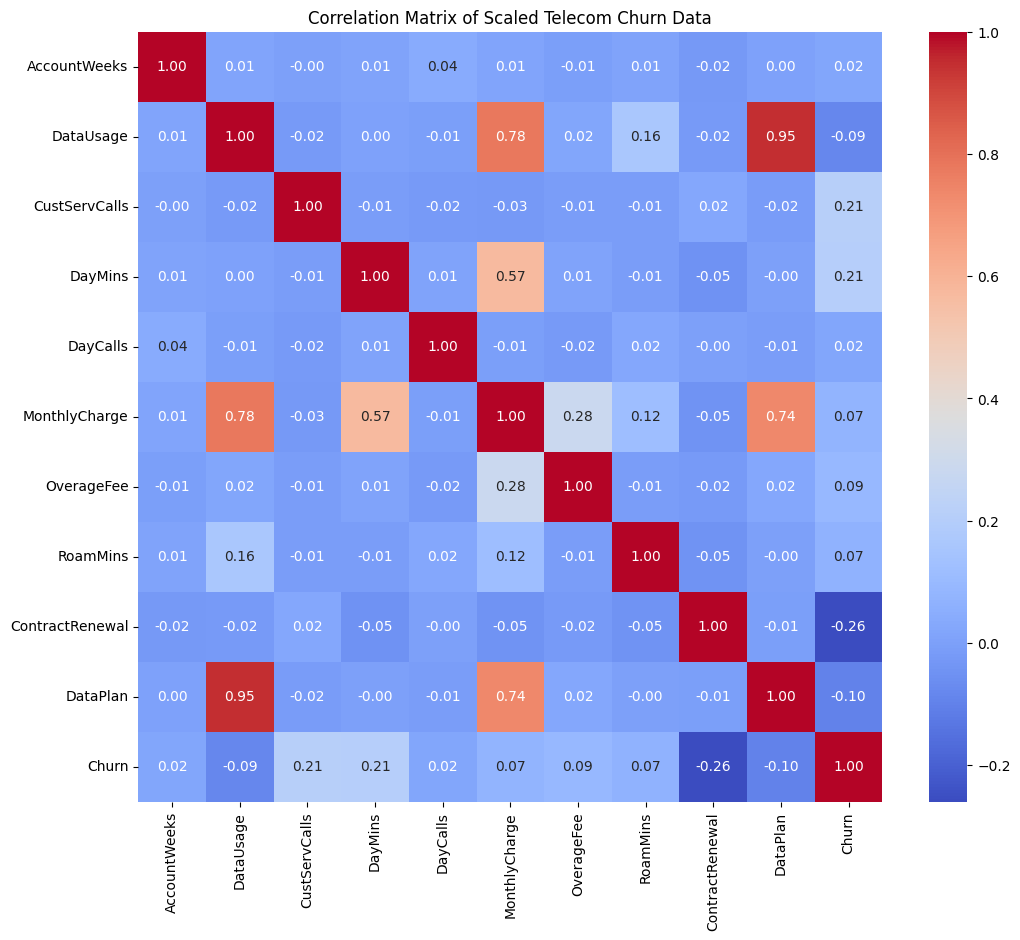

In [13]:
# Calculate the correlation matrix
corr_matrix = df_scaled.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Scaled Telecom Churn Data')
plt.show()

In [14]:
df = df.drop('DataPlan', axis = 1)

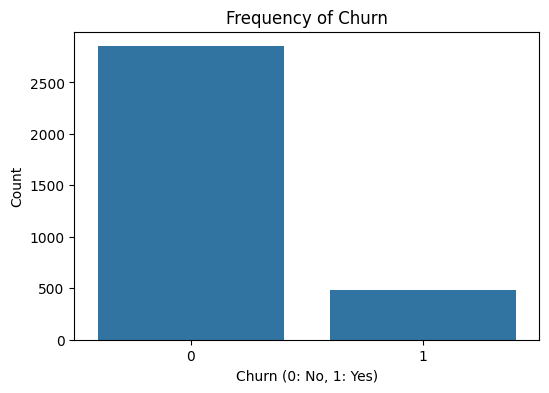

In [15]:
# Plot the frequency of churn
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Frequency of Churn')
plt.xlabel('Churn (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()


# Handling target imbalance (Over-Sampling)

In [16]:
from imblearn.over_sampling import SMOTE

# Define features (X) and target (y) from the scaled DataFrame
X = df_scaled.drop('Churn', axis=1)
y = df_scaled['Churn']

# Calculate class counts to determine majority and minority classes
class_counts = y.value_counts()
majority_class_label = class_counts.idxmax()
minority_class_label = class_counts.idxmin()
majority_count = class_counts.max()

# Apply SMOTE with a specific sampling strategy (e.g., balance minority to 50% of majority)
smote = SMOTE(sampling_strategy={minority_class_label: int(majority_count * 0.5)}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(y_resampled.value_counts()) # Ver distribución balanceada

Churn
0    2850
1    1425
Name: count, dtype: int64


## Classes Weighted

In [17]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Definir las clases
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y
)

print(dict(enumerate(class_weights)))  # Muestra los pesos por clase

{0: np.float64(0.5847368421052631), 1: np.float64(3.450310559006211)}


# Neural Network

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

In [19]:
print(X_train.shape)
print(X_test.shape)

(3420, 10)
(855, 10)


In [20]:
num_columns = X_train.shape[1]
num_columns

10

In [21]:
model = keras.Sequential([
    keras.layers.Input(shape=(num_columns,)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [23]:
history = model.fit(X_train, y_train, epochs= 20, validation_data= (X_test, y_test), class_weight=dict(enumerate(class_weights)))

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.3764 - loss: 0.8602 - val_accuracy: 0.6187 - val_loss: 0.7083
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6400 - loss: 0.6322 - val_accuracy: 0.8000 - val_loss: 0.5259
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7721 - loss: 0.5358 - val_accuracy: 0.8398 - val_loss: 0.4570
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8126 - loss: 0.4848 - val_accuracy: 0.8047 - val_loss: 0.4943
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8151 - loss: 0.4781 - val_accuracy: 0.8105 - val_loss: 0.5055
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8200 - loss: 0.4700 - val_accuracy: 0.8433 - val_loss: 0.4432
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8368 - loss: 0.4413 - val_accuracy: 0.8292 - val_loss: 0.4661
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8346 - loss: 0.4382 - val_accuracy: 0

In [24]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


### Confussion Matrix

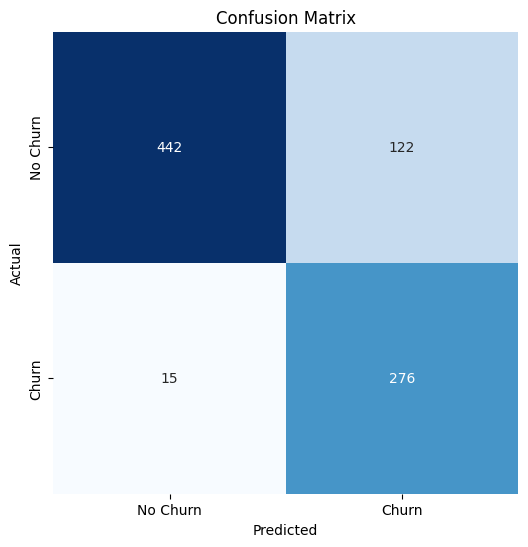

In [25]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Classification Report

In [26]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.78      0.87       564
           1       0.69      0.95      0.80       291

    accuracy                           0.84       855
   macro avg       0.83      0.87      0.83       855
weighted avg       0.87      0.84      0.84       855



# Random Search (Fine-tuning)

In [27]:
def build_model(hp):
  model = keras.Sequential([
      keras.layers.Input(shape=(num_columns,)),
  ])

  model.add(keras.layers.Dense(units = hp.Int('units_layer1', min_value = 10, max_value = 16, step=2),
                               activation = hp.Choice('activation_layer1', values = ['relu', 'tanh'])))

  model.add(keras.layers.Dropout(rate = hp.Float('dropout_layer1', min_value =0.0, max_value = 0.5, step = 0.1)))

  if hp.Boolean('Second_layer'):
        model.add(keras.layers.Dense(units=hp.Int('units_layer2', min_value = 5, max_value = 10, step=1),
                                 activation = hp.Choice('activation_layer2', values = ['relu', 'tanh'])))
        model.add(keras.layers.Dropout(rate = hp.Float('dropout_layer2', min_value =0.0, max_value = 0.5, step = 0.1)))

  model.add(keras.layers.Dense(1, activation = 'sigmoid'))

  model.compile(
      optimizer = hp.Choice('optimizer', values = ['adam', 'adamW']),
      loss = 'binary_crossentropy',
      metrics = ['accuracy']
  )

  return model


In [28]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 6.2 MB/s eta 0:00:00


In [29]:
import keras_tuner

In [30]:
import keras_tuner as kt

tuner = kt.RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 3,
    directory = 'random_search',
    project_name = 'telecom_churn'
)

In [31]:
tuner.search(X_train, y_train, epochs = 20, validation_data = (X_test,y_test), class_weight=dict(enumerate(class_weights)))

Trial 10 Complete [00h 00m 41s]
val_accuracy: 0.7656919956207275

Best val_accuracy So Far: 0.8023391763369242
Total elapsed time: 00h 07m 15s


In [32]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print('Best Hyperparameters:')
print(f'Units Layer 1: {best_hps.get("units_layer1")}')
print(f'Optimizer: {best_hps.get("optimizer")}')
print(f'Dropout Layer 1: {best_hps.get("dropout_layer1")}')

Best Hyperparameters:
Units Layer 1: 16
Optimizer: adamW
Dropout Layer 1: 0.1


# Best Model Training

In [33]:
best_model = tuner.hypermodel.build(best_hps)

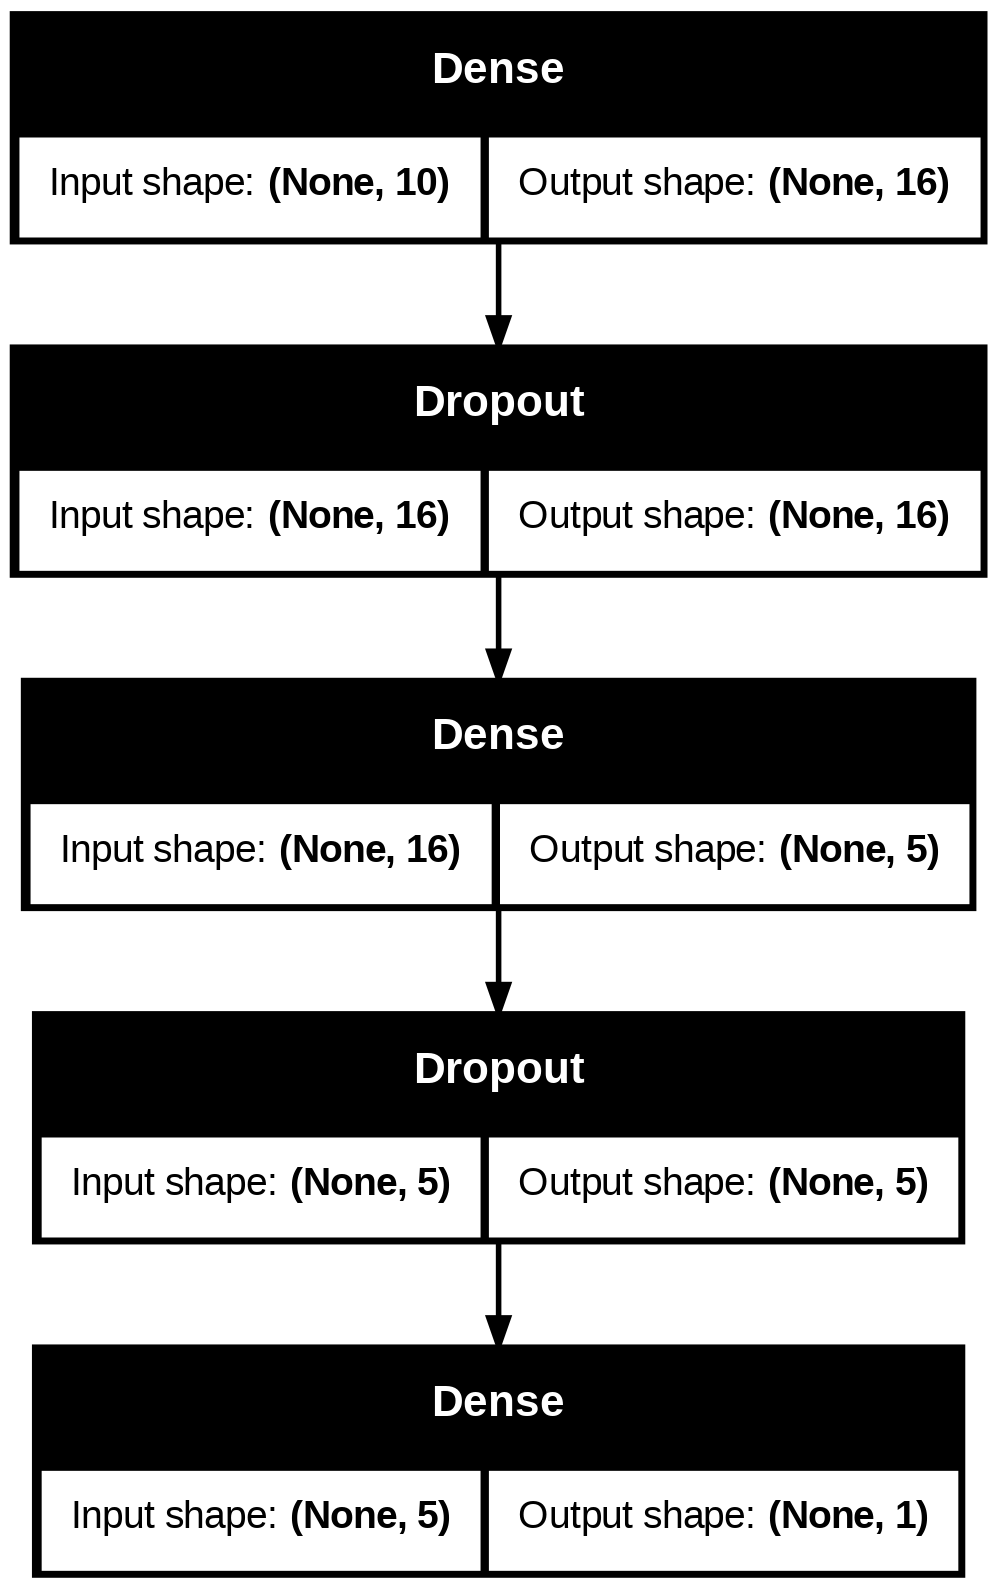

In [34]:
keras.utils.plot_model(best_model, show_shapes=True)

In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [36]:
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stop], class_weight=dict(enumerate(class_weights)))

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.3427 - loss: 0.9554 - val_accuracy: 0.3404 - val_loss: 0.8223
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3329 - loss: 0.8065 - val_accuracy: 0.3404 - val_loss: 0.8205
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3270 - loss: 0.7261 - val_accuracy: 0.3404 - val_loss: 0.7891
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3375 - loss: 0.6944 - val_accuracy: 0.3404 - val_loss: 0.7545
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3386 - loss: 0.6673 - val_accuracy: 0.3404 - val_loss: 0.7271
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4088 - loss: 0.6317 - val_accuracy: 0.5930 - val_loss: 0.7161
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5730 - loss: 0.6172 - val_accuracy: 0.6269 - val_loss: 0.6962
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6060 - loss: 0.6023 - val_accuracy: 0

# Metrics

In [37]:
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


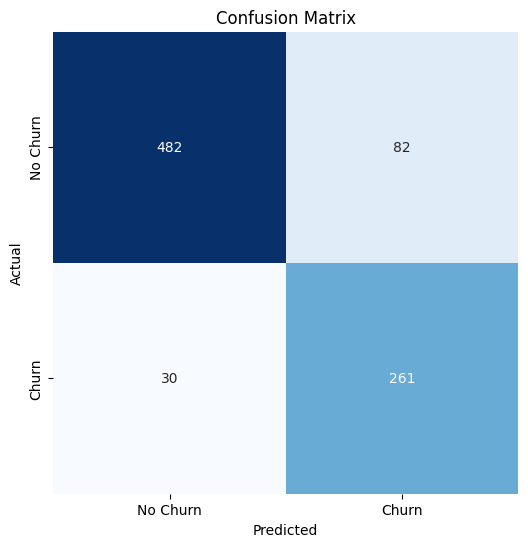

In [38]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [39]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.85      0.90       564
           1       0.76      0.90      0.82       291

    accuracy                           0.87       855
   macro avg       0.85      0.88      0.86       855
weighted avg       0.88      0.87      0.87       855



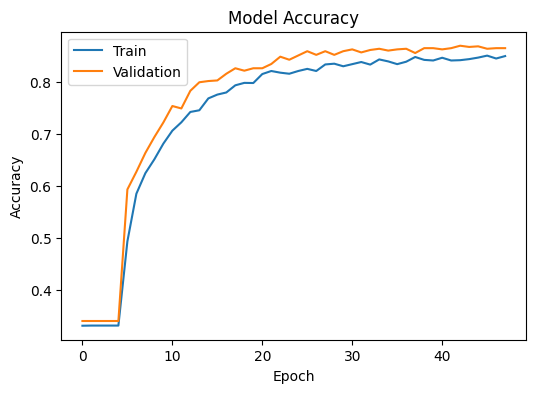

In [40]:
plt.figure(figsize=(6, 4))
plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

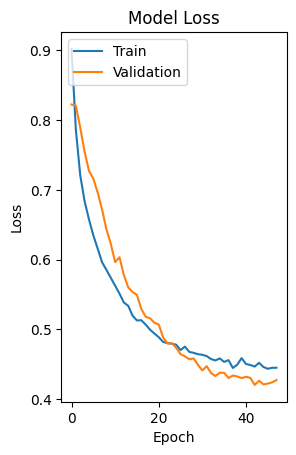

In [41]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


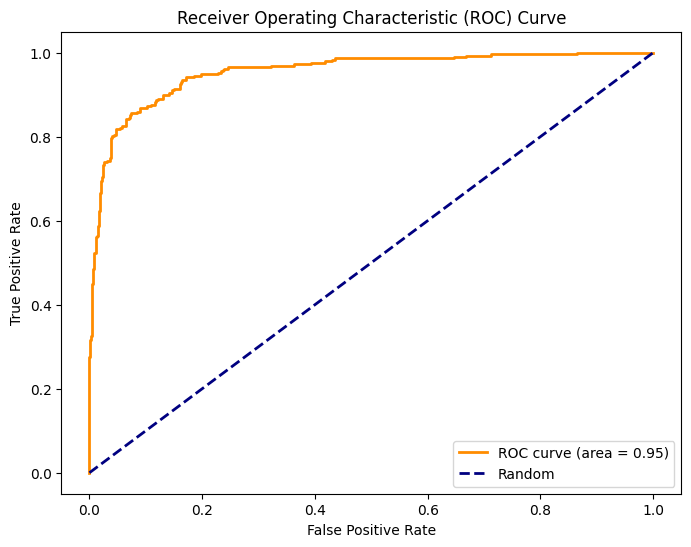

In [42]:
# Predict probabilities for the test set
y_pred_prob = model.predict(X_test).ravel()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Saved Model

In [43]:
best_model.save('telecom_churn_model.keras')